# CHELSA 2010 Mean Temperature and Precipitation

In [1]:
import rioxarray as rio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [7]:
sample_pr = "/home/tkhan/biodt/storage/finetune/chelsa/pr_raw/CHELSA_pr_02_2010_V.2.1.tif"
sample_tas = "/home/tkhan/biodt/storage/finetune/chelsa/tas_raw/CHELSA_tas_02_2010_V.2.1.tif"

# Define Grid: Defines a lat/lon bounding box over Europe/North Africa/West Asia | Creates grid bins every 0.25° for later grouping.
LAT_START, LAT_END = 32.0, 72.0
LON_START, LON_END = -25.0, 45.0
GRID_LAT = np.round(np.arange(LAT_START, LAT_END + 1e-6, 0.25), 3)
GRID_LON = np.round(np.arange(LON_START, LON_END + 1e-6, 0.25), 3)

# Create a mask for the region of interest
#mask = (pr >= 0) & (tas >= -100)  # Assuming valid data is non-negative for pr and above -30 for tas
# Apply the mask to the data
#pr_masked = np.where(mask, pr, np.nan)
#tas_masked = np.where(mask, tas, np.nan)

# Use rioxarray to read the data, squeeze the band to xy-shape
pr_xr = rio.open_rasterio(sample_pr).squeeze("band", drop=True)
tas_xr = rio.open_rasterio(sample_tas).squeeze("band", drop=True)


In [8]:

# Group the data by the defined grid and downsample by taking mean of the bin
pr_xr_coarse = pr_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()
tas_xr_coarse = tas_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()



In [9]:
print("Original precipitation: min", float(pr_xr.min()), "max", float(pr_xr.max()), "mean", float(pr_xr.mean()))
print("Coarse precipitation: min", float(pr_xr_coarse.min()), "max", float(pr_xr_coarse.max()), "mean", float(pr_xr_coarse.mean()))

Original precipitation: min 0.0 max 1834980.0 mean 7499.589370026696
Coarse precipitation: min 15.529999999999998 max 68048.17333333332 mean 7777.014932266867


In [10]:
print("Original temperature: min", float(tas_xr.min()), "max", float(tas_xr.max()), "mean", float(tas_xr.mean()))
print("Coarse temperature: min", float(tas_xr_coarse.min()), "max", float(tas_xr_coarse.max()), "mean", float(tas_xr_coarse.mean()))

Original temperature: min 2274.0 max 3102.0 mean 2778.2877563546544
Coarse temperature: min 2507.296666666667 max 2914.837777777778 mean 2751.974793774802


### Grouping validation

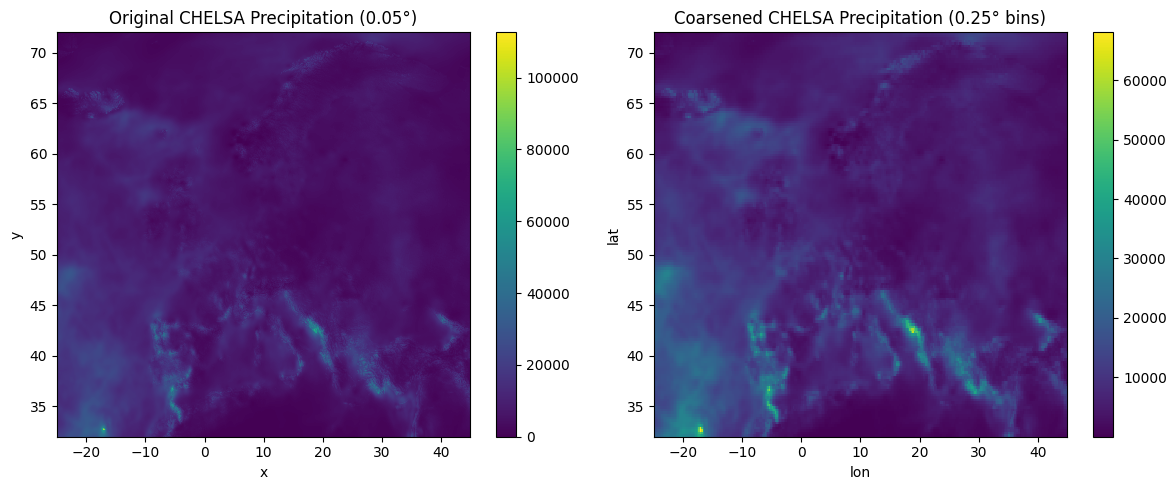

In [19]:
# Spatial crop before plotting
pr_roi = pr_xr.sel(
    y=slice(LAT_END, LAT_START),  # descending order for latitude
    x=slice(LON_START, LON_END)
)
# Plot original CHELSA precipitation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
pr_roi.plot(cmap="viridis")
plt.title("Original CHELSA Precipitation (0.05°)")

# Plot grouped (coarsened) precipitation
plt.subplot(1, 2, 2)
pr_xr_coarse.plot(cmap="viridis")
plt.title("Coarsened CHELSA Precipitation (0.25° bins)")

plt.tight_layout()
plt.show()

### Plotting final datasets

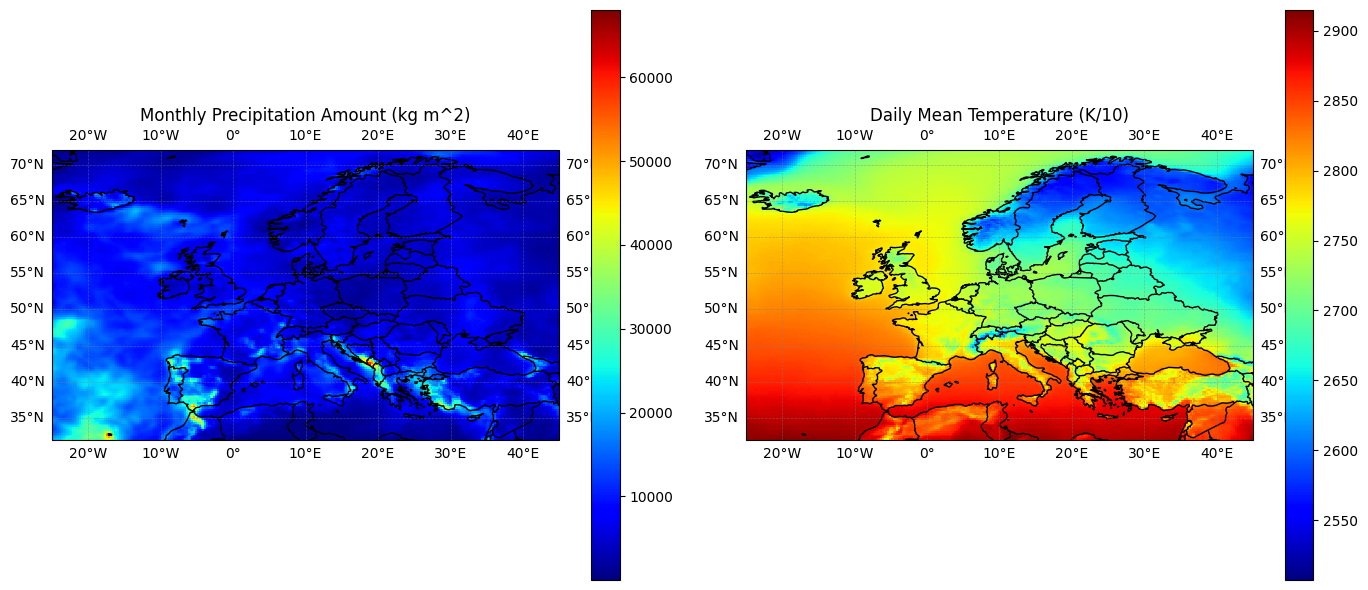

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pr_xr_coarse = pr_xr_coarse.rename({'x_bins': 'lon', 'y_bins': 'lat'})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Precipitation plot
pr_xr_coarse.plot(ax=axes[0], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[0].set_title("Monthly Precipitation Amount (kg m^2)")
axes[0].add_feature(cfeature.BORDERS, linewidth=1)
axes[0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Temperature plot
tas_xr_coarse.plot(ax=axes[1], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[1].set_title("Daily Mean Temperature (K/10)")
axes[1].add_feature(cfeature.BORDERS, linewidth=1)
axes[1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()